# Clear Nature - (Our own) shadow detection model


# Architecture: UNET with pre-trained ResNet34 encoder (due to limited dataset of ~2000 images)
# Loss: Suggested by claude
BCE → Sharp, accurate boundaries\
Dice → Robust to imbalance, good overall segmentation
# Dataset: https://www.kaggle.com/datasets/sabarinathan/istd-dataset

In [1]:
# ============================================================================
# 1. SETUP AND INSTALLATIONS
# ============================================================================

!pip install -q kagglehub segmentation-models-pytorch albumentations

import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import kagglehub



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.5 MB/s eta 0:00:00


In [2]:
# ============================================================================
# 2. DOWNLOAD DATASET
# ============================================================================

print("Downloading ISTD dataset...")
path = kagglehub.dataset_download("sabarinathan/istd-dataset")
print("Path to dataset files:", path)



100%|██████████| 2.00G/2.00G [00:21<00:00, 99.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1


In [3]:
# ============================================================================
# 3. DATASET CLASS
# ============================================================================

class ShadowDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir: Path to dataset
            split: 'train' or 'test'
            transform: Albumentations transform
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform

        # ISTD Dataset structure: ISTD_Dataset/train/train_A, etc.
        self.img_dir = self.root_dir / 'ISTD_Dataset' / split / f'{split}_A'
        self.mask_dir = self.root_dir / 'ISTD_Dataset' / split / f'{split}_B'

        if not self.img_dir.exists():
            raise ValueError(f"Image directory not found: {self.img_dir}")
        if not self.mask_dir.exists():
            raise ValueError(f"Mask directory not found: {self.mask_dir}")

        # Get all image files
        self.images = sorted(list(self.img_dir.glob('*.png')) + list(self.img_dir.glob('*.jpg')))

        if len(self.images) == 0:
            raise ValueError(f"No images found in {self.img_dir}")

        print(f"\n✓ {split.upper()} - Found {len(self.images)} images")
        print(f"  Images: {self.img_dir}")
        print(f"  Masks:  {self.mask_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        mask_name = img_path.name
        mask_path = self.mask_dir / mask_name

        if not mask_path.exists():
            # Try without extension change
            mask_path = self.mask_dir / mask_name.replace('.jpg', '.png')

        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Binarize mask (shadow = 1, non-shadow = 0)
        mask = (mask > 127).astype(np.float32)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)  # Add channel dimension to mask


In [4]:
# ============================================================================
# 4. DATA AUGMENTATION
# ============================================================================

IMG_SIZE = 256

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])



/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-167156800.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [5]:
# ============================================================================
# 5. CREATE DATASETS AND DATALOADERS
# ============================================================================

train_dataset = ShadowDataset(path, split='train', transform=train_transform)
test_dataset = ShadowDataset(path, split='test', transform=val_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nDataset sizes:")
print(f"Training: {len(train_dataset)} images")
print(f"Testing: {len(test_dataset)} images")




✓ TRAIN - Found 1330 images
  Images: /root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/train/train_A
  Masks:  /root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/train/train_B

✓ TEST - Found 540 images
  Images: /root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/test/test_A
  Masks:  /root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/test/test_B

Dataset sizes:
Training: 1330 images
Testing: 540 images



Visualizing sample data:


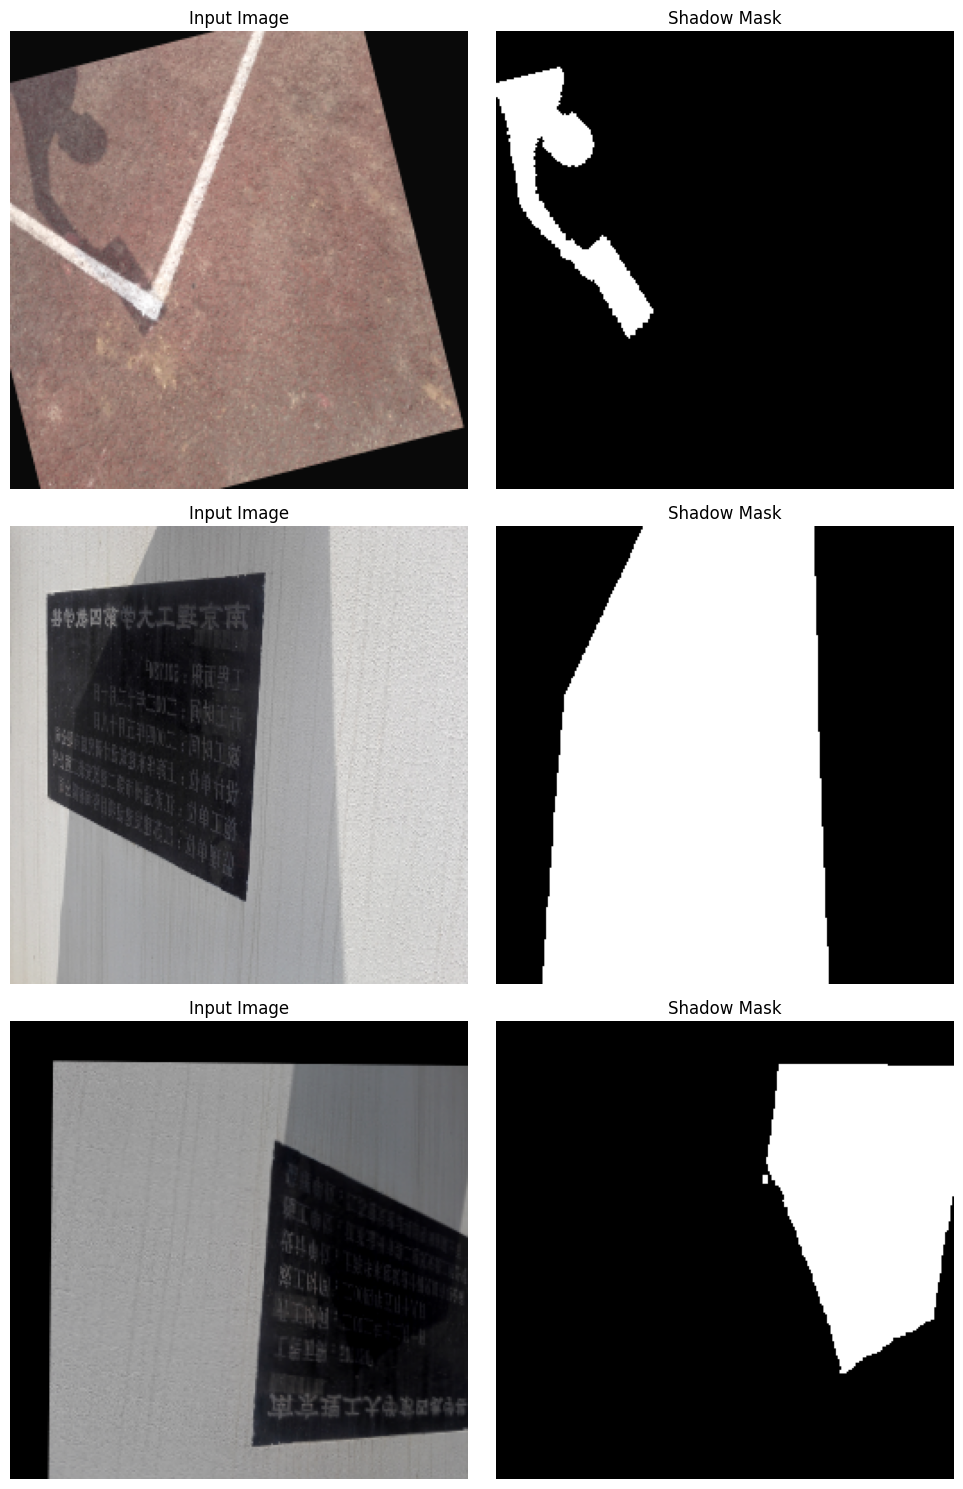

In [6]:
# ============================================================================
# 6. VISUALIZE SAMPLE DATA
# ============================================================================

def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        img, mask = dataset[i]

        # Denormalize image for visualization
        img_display = img.permute(1, 2, 0).numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title('Shadow Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing sample data:")
visualize_samples(train_dataset)



In [7]:
# ============================================================================
# 7. CREATE UNET MODEL
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Using segmentation_models_pytorch for a robust UNET implementation
model = smp.Unet(
    encoder_name="resnet34",        # Encoder backbone
    encoder_weights="imagenet",     # Pre-trained weights
    in_channels=3,                  # RGB input
    classes=1,                      # Binary segmentation (shadow/no-shadow)
    activation=None,                # We'll apply sigmoid in loss
)

model = model.to(device)

print(f"\nModel created: UNET with ResNet34 encoder")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")




Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


Model created: UNET with ResNet34 encoder
Total parameters: 24,436,369


In [8]:
# ============================================================================
# 8. Hyper Parameters
# ============================================================================

NUM_EPOCHS = 30

In [9]:
# ============================================================================
# 9. LOSS FUNCTION AND METRICS
# ============================================================================

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

def dice_coefficient(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)



In [10]:
# ============================================================================
# 10. TRAINING LOOP
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0

    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_dice += dice_coefficient(outputs, masks)

        pbar.set_postfix({'loss': loss.item(), 'dice': dice_coefficient(outputs, masks)})

    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    return epoch_loss, epoch_dice

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_dice += dice_coefficient(outputs, masks)

            pbar.set_postfix({'loss': loss.item(), 'dice': dice_coefficient(outputs, masks)})

    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    return epoch_loss, epoch_dice



In [11]:
# ============================================================================
# 11. TRAIN THE MODEL
# ============================================================================

best_dice = 0.0
train_losses, val_losses = [], []
train_dices, val_dices = [], []

print("\nStarting training...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = validate_epoch(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

    # Save best model
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), 'best_shadow_unet.pth')
        print(f"✓ Saved best model with Dice: {best_dice:.4f}")




Starting training...

Epoch 1/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s, loss=0.975, dice=0.809]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 1.1730, Train Dice: 0.5701
Val Loss: 0.9819, Val Dice: 0.7980
✓ Saved best model with Dice: 0.7980

Epoch 2/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s, loss=0.733, dice=0.864]


Train Loss: 0.7919, Train Dice: 0.8269
Val Loss: 0.7212, Val Dice: 0.8549
✓ Saved best model with Dice: 0.8549

Epoch 3/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.83it/s, loss=0.639, dice=0.869]


Train Loss: 0.6563, Train Dice: 0.8633
Val Loss: 0.6962, Val Dice: 0.8258

Epoch 4/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.75it/s, loss=0.558, dice=0.89]


Train Loss: 0.5473, Train Dice: 0.8945
Val Loss: 0.5389, Val Dice: 0.8902
✓ Saved best model with Dice: 0.8902

Epoch 5/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s, loss=0.551, dice=0.858]


Train Loss: 0.4778, Train Dice: 0.9048
Val Loss: 0.4745, Val Dice: 0.8990
✓ Saved best model with Dice: 0.8990

Epoch 6/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s, loss=0.446, dice=0.901]


Train Loss: 0.4181, Train Dice: 0.9142
Val Loss: 0.4193, Val Dice: 0.9113
✓ Saved best model with Dice: 0.9113

Epoch 7/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s, loss=0.448, dice=0.876]


Train Loss: 0.3670, Train Dice: 0.9232
Val Loss: 0.3704, Val Dice: 0.9181
✓ Saved best model with Dice: 0.9181

Epoch 8/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.64it/s, loss=0.363, dice=0.912]


Train Loss: 0.3232, Train Dice: 0.9307
Val Loss: 0.3385, Val Dice: 0.9234
✓ Saved best model with Dice: 0.9234

Epoch 9/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s, loss=0.376, dice=0.892]


Train Loss: 0.2911, Train Dice: 0.9337
Val Loss: 0.3377, Val Dice: 0.9130

Epoch 10/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s, loss=0.317, dice=0.906]


Train Loss: 0.2713, Train Dice: 0.9333
Val Loss: 0.3088, Val Dice: 0.9141

Epoch 11/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s, loss=0.215, dice=0.952]


Train Loss: 0.2553, Train Dice: 0.9338
Val Loss: 0.2443, Val Dice: 0.9343
✓ Saved best model with Dice: 0.9343

Epoch 12/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s, loss=0.225, dice=0.942]


Train Loss: 0.2268, Train Dice: 0.9402
Val Loss: 0.2380, Val Dice: 0.9340

Epoch 13/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s, loss=0.262, dice=0.913]


Train Loss: 0.2159, Train Dice: 0.9404
Val Loss: 0.2221, Val Dice: 0.9326

Epoch 14/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s, loss=0.216, dice=0.937]


Train Loss: 0.2063, Train Dice: 0.9401
Val Loss: 0.2164, Val Dice: 0.9358
✓ Saved best model with Dice: 0.9358

Epoch 15/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s, loss=0.194, dice=0.945]


Train Loss: 0.1960, Train Dice: 0.9414
Val Loss: 0.2265, Val Dice: 0.9284

Epoch 16/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s, loss=0.182, dice=0.95]


Train Loss: 0.1858, Train Dice: 0.9429
Val Loss: 0.2101, Val Dice: 0.9319

Epoch 17/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s, loss=0.178, dice=0.943]


Train Loss: 0.1748, Train Dice: 0.9453
Val Loss: 0.2266, Val Dice: 0.9218

Epoch 18/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s, loss=0.194, dice=0.931]


Train Loss: 0.1724, Train Dice: 0.9438
Val Loss: 0.1929, Val Dice: 0.9335

Epoch 19/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s, loss=0.176, dice=0.94]


Train Loss: 0.1553, Train Dice: 0.9498
Val Loss: 0.1868, Val Dice: 0.9355

Epoch 20/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s, loss=0.138, dice=0.956]


Train Loss: 0.1479, Train Dice: 0.9520
Val Loss: 0.1848, Val Dice: 0.9374
✓ Saved best model with Dice: 0.9374

Epoch 21/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s, loss=0.138, dice=0.955]


Train Loss: 0.1390, Train Dice: 0.9543
Val Loss: 0.1795, Val Dice: 0.9376
✓ Saved best model with Dice: 0.9376

Epoch 22/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.90it/s, loss=0.151, dice=0.944]


Train Loss: 0.1336, Train Dice: 0.9553
Val Loss: 0.1747, Val Dice: 0.9375

Epoch 23/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.74it/s, loss=0.131, dice=0.953]


Train Loss: 0.1277, Train Dice: 0.9567
Val Loss: 0.1800, Val Dice: 0.9354

Epoch 24/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s, loss=0.124, dice=0.956]


Train Loss: 0.1296, Train Dice: 0.9548
Val Loss: 0.1716, Val Dice: 0.9356

Epoch 25/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s, loss=0.155, dice=0.94]


Train Loss: 0.1348, Train Dice: 0.9512
Val Loss: 0.1669, Val Dice: 0.9357

Epoch 26/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.61it/s, loss=0.128, dice=0.954]


Train Loss: 0.1240, Train Dice: 0.9558
Val Loss: 0.1682, Val Dice: 0.9368

Epoch 27/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s, loss=0.143, dice=0.942]


Train Loss: 0.1146, Train Dice: 0.9588
Val Loss: 0.1725, Val Dice: 0.9326

Epoch 28/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.79it/s, loss=0.106, dice=0.959]


Train Loss: 0.1142, Train Dice: 0.9582
Val Loss: 0.1447, Val Dice: 0.9424
✓ Saved best model with Dice: 0.9424

Epoch 29/30


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s, loss=0.113, dice=0.956]


Train Loss: 0.1067, Train Dice: 0.9610
Val Loss: 0.1450, Val Dice: 0.9429
✓ Saved best model with Dice: 0.9429

Epoch 30/30


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s, loss=0.113, dice=0.955]


Train Loss: 0.1074, Train Dice: 0.9601
Val Loss: 0.1543, Val Dice: 0.9385


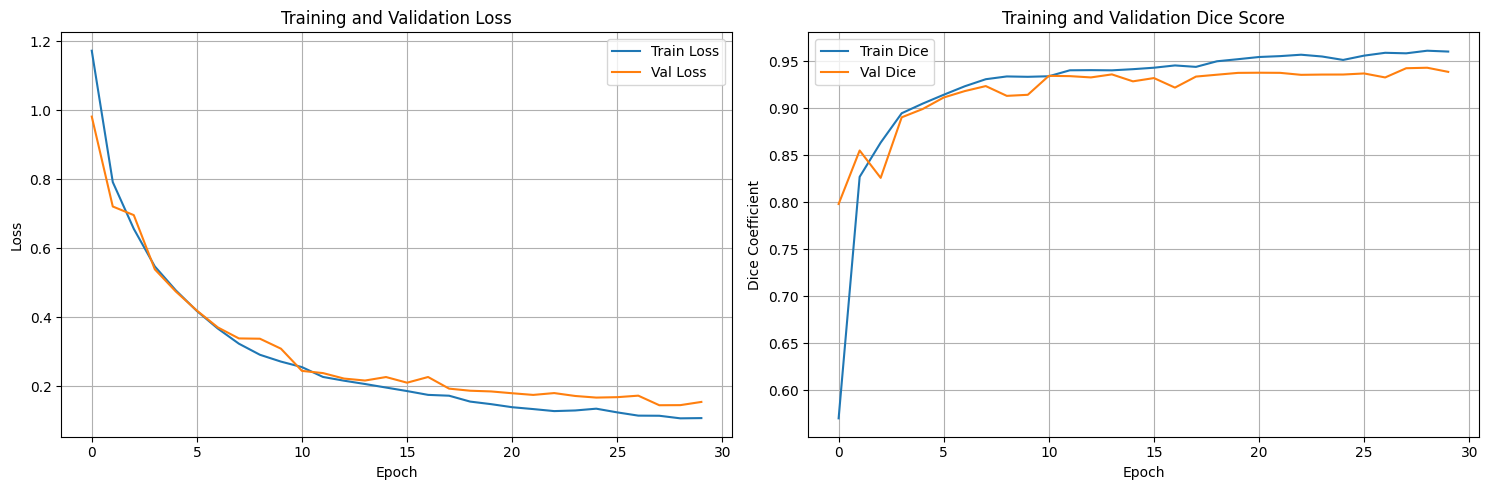


Best Validation Dice Score: 0.9429


In [12]:
# ============================================================================
# 12. PLOT TRAINING RESULTS
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_dices, label='Train Dice')
ax2.plot(val_dices, label='Val Dice')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Dice Coefficient')
ax2.set_title('Training and Validation Dice Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Dice Score: {best_dice:.4f}")




Visualizing predictions on test set:


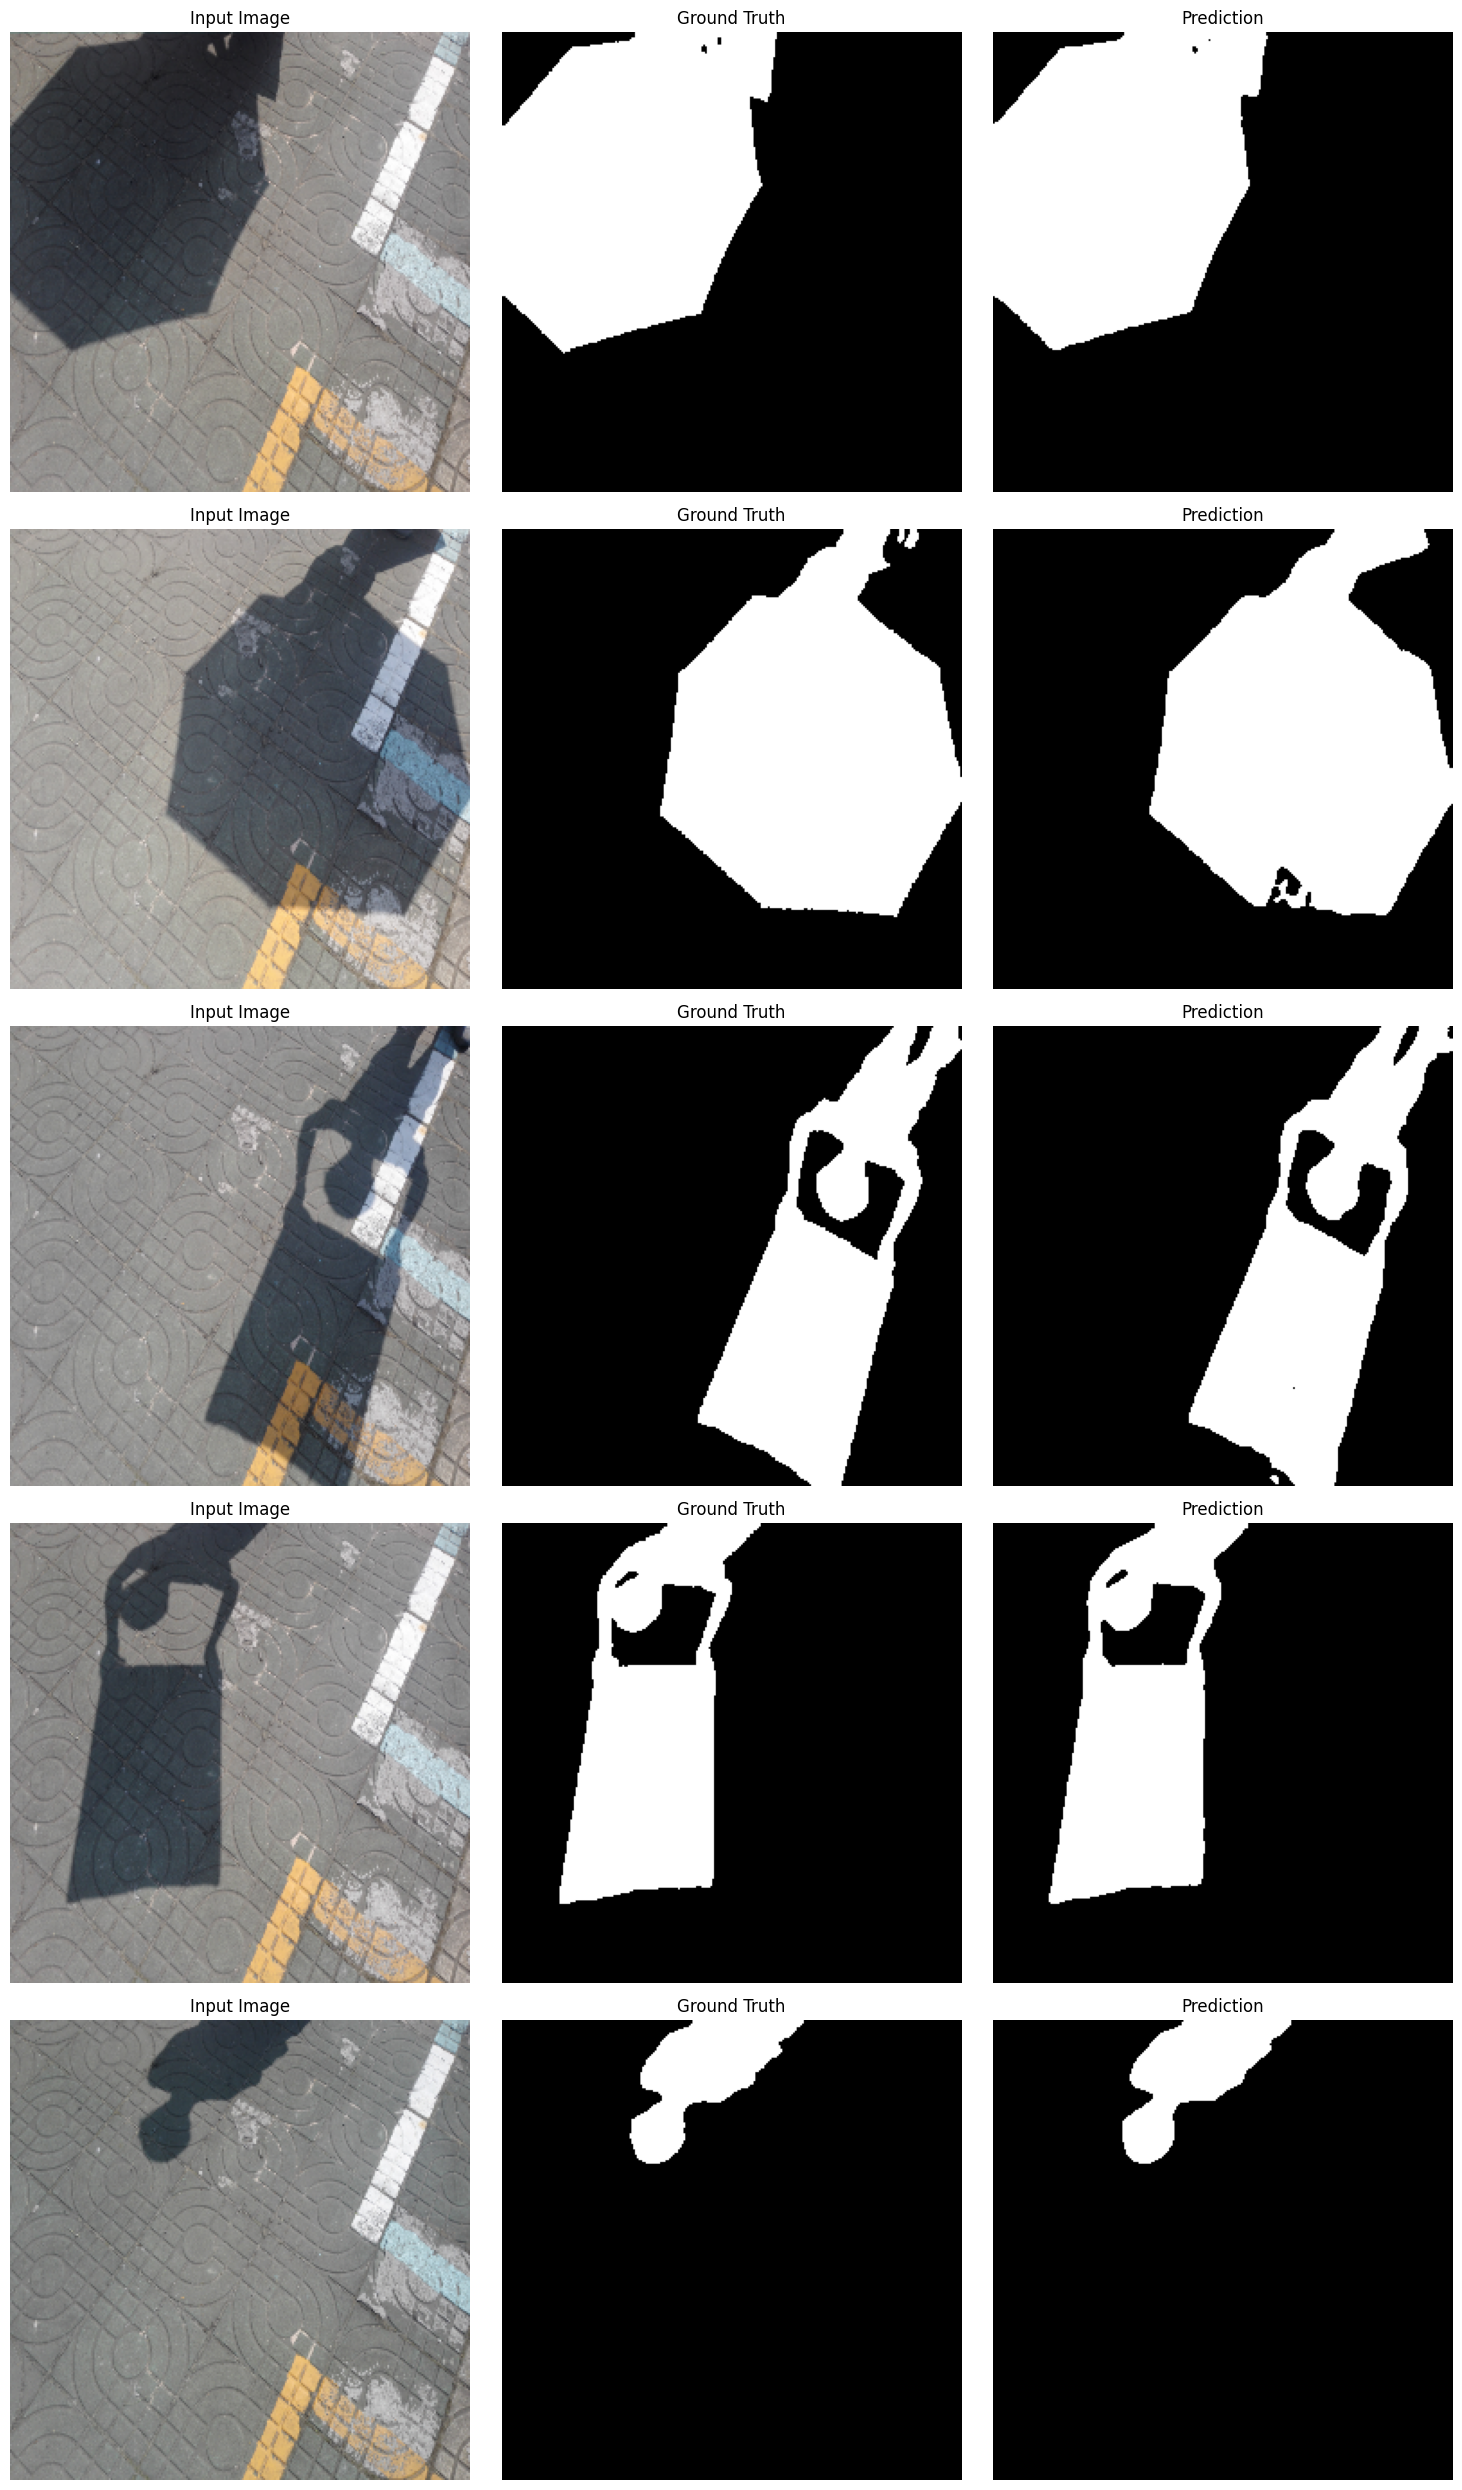

In [13]:
# ============================================================================
# 13. VISUALIZE PREDICTIONS
# ============================================================================

def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            img, mask = dataset[i]

            # Predict
            img_input = img.unsqueeze(0).to(device)
            pred = model(img_input)
            pred = torch.sigmoid(pred).cpu().squeeze()
            pred_binary = (pred > 0.5).float()

            # Denormalize image
            img_display = img.permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)

            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask.squeeze(), cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred_binary, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Load best model
model.load_state_dict(torch.load('best_shadow_unet.pth'))
print("\nVisualizing predictions on test set:")
visualize_predictions(model, test_dataset, device)



In [14]:
# ============================================================================
# 14. EXPORT MODEL FOR INFERENCE
# ============================================================================

class ShadowDetector(nn.Module):
    """Wrapper class for easy inference"""
    def __init__(self, model):
        super(ShadowDetector, self).__init__()
        self.model = model
        self.transform = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

    def forward(self, x):
        return torch.sigmoid(self.model(x))

    def predict(self, image, threshold=0.5):
        """
        Predict shadow mask from numpy image

        Args:
            image: numpy array (H, W, 3) in RGB format
            threshold: threshold for binary mask

        Returns:
            Binary mask (H, W) as numpy array
        """
        original_size = image.shape[:2]

        # Transform
        transformed = self.transform(image=image)
        img_tensor = transformed['image'].unsqueeze(0)

        # Predict
        self.model.eval()
        with torch.no_grad():
            if next(self.model.parameters()).is_cuda:
                img_tensor = img_tensor.cuda()

            output = self.forward(img_tensor)
            pred = output.cpu().squeeze().numpy()

        # Resize back to original size
        pred = cv2.resize(pred, (original_size[1], original_size[0]))
        binary_mask = (pred > threshold).astype(np.uint8) * 255

        return binary_mask

# Create wrapped model
shadow_detector = ShadowDetector(model)
shadow_detector.eval()

# Save the wrapped model
torch.save({
    'model_state_dict': model.state_dict(),
    'img_size': IMG_SIZE,
}, 'shadow_detector.pth')

print("\n✓ Model saved as 'shadow_detector.pth'")



# ============================================================================
# SAVE MODEL PROPERLY (Add this to training notebook)
# ============================================================================

print("\n" + "="*80)
print("SAVING MODEL FILES")
print("="*80)

# Method 1: Save complete model (RECOMMENDED)
torch.save({
    'model_state_dict': model.state_dict(),
    'img_size': IMG_SIZE,
    'encoder_name': 'resnet34',
    'model_config': {
        'encoder_name': 'resnet34',
        'in_channels': 3,
        'classes': 1,
    }
}, 'shadow_detector_complete.pth')

print("✓ Saved: shadow_detector_complete.pth")

# Method 2: Save just weights (smaller file)
torch.save(model.state_dict(), 'shadow_weights_only.pth')
print("✓ Saved: shadow_weights_only.pth")

# Method 3: Save entire model (easiest to load, but larger)
torch.save(model, 'shadow_model_full.pth')
print("✓ Saved: shadow_model_full.pth")

# Download files from Colab
from google.colab import files
print("\nDownloading model files...")
files.download('shadow_detector_complete.pth')
files.download('shadow_weights_only.pth')
files.download('shadow_model_full.pth')

print("\n✓ All model files saved and ready to download!")
print("="*80)


✓ Model saved as 'shadow_detector.pth'

SAVING MODEL FILES
✓ Saved: shadow_detector_complete.pth
✓ Saved: shadow_weights_only.pth
✓ Saved: shadow_model_full.pth



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ All model files saved and ready to download!


In [ ]:
# ============================================================================
# 15.1. PREPARE FOR EXAMPLE USAGE ON PROJECT IMAGES
# ============================================================================

# # Load the model
# import torch
# import segmentation_models_pytorch as smp
# import cv2
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# # Recreate model architecture
# model = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=3,
#     classes=1,
#     activation=None,
# )

def process_image_folder(folder_path, model, device, threshold=0.5, save_dir=None):
    """
    Process all images in a folder and generate shadow masks

    Args:
        folder_path: Path to folder containing images
        model: Trained model
        device: torch device
        threshold: Threshold for binary mask (default 0.5)
        save_dir: Optional directory to save masks (if None, only displays)

    Returns:
        List of (image, mask) tuples
    """
    folder = Path(folder_path)

    if not folder.exists():
        print(f"❌ Folder not found: {folder_path}")
        return []

    # Find all images
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    image_files = []
    for ext in image_extensions:
        image_files.extend(folder.glob(ext))
        image_files.extend(folder.glob(ext.upper()))

    image_files = sorted(image_files)

    if len(image_files) == 0:
        print(f"❌ No images found in {folder_path}")
        return []

    print(f"\n✓ Found {len(image_files)} images")

    # Create save directory if specified
    if save_dir:
        save_path = Path(save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        print(f"✓ Saving masks to: {save_path}")

    # Process images
    model.eval()
    results = []

    print("\nProcessing images...")
    for img_path in tqdm(image_files):
        # Read image
        image = cv2.imread(str(img_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = image_rgb.shape[:2]

        # Transform
        transformed = val_transform(image=image_rgb)
        img_tensor = transformed['image'].unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = torch.sigmoid(model(img_tensor))
            pred = output.cpu().squeeze().numpy()

        # Resize back to original size
        pred = cv2.resize(pred, (original_size[1], original_size[0]))
        mask = (pred > threshold).astype(np.uint8) * 255

        results.append((image_rgb, mask, img_path.name))

        # Save mask if directory specified
        if save_dir:
            mask_filename = save_path / f"{img_path.stem}_mask.png"
            cv2.imwrite(str(mask_filename), mask)

    print(f"✓ Processed {len(results)} images")
    return results

def visualize_results(results, num_display=10):
    """
    Display results in a grid

    Args:
        results: List of (image, mask, filename) tuples
        num_display: Number of results to display
    """
    num_display = min(num_display, len(results))

    if num_display == 0:
        print("No results to display")
        return

    fig, axes = plt.subplots(num_display, 3, figsize=(15, 5*num_display))

    # Handle single image case
    if num_display == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_display):
        image, mask, filename = results[i]

        # Original image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'Original: {filename}')
        axes[i, 0].axis('off')

        # Shadow mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Shadow Mask')
        axes[i, 1].axis('off')

        # Overlay (shadows in red)
        overlay = image.copy()
        red_mask = np.zeros_like(image)
        red_mask[:, :, 0] = mask  # Red channel
        overlay = cv2.addWeighted(overlay, 0.7, red_mask, 0.3, 0)

        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title('Overlay (Shadows in Red)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# ============================================================================
# 15.2. EXAMPLE USAGE
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
folder_path = '/content/test_images/'

results = process_image_folder(folder_path, model, device, threshold=0.5)

visualize_results(results)

Output hidden; open in https://colab.research.google.com to view.

# 2 Possibilities to filter non-relevant shadow:
1) Allow nearby shadows even if they don't touch\
2) Allow only touching shadows

Both functions return the shadow mask, which then needs to be combined with the people mask.


In [ ]:
def filter_shadows_near_people(shadow_mask, people_mask, max_distance=50):
    """
    Filter shadow mask to only keep shadows near people

    Args:
        shadow_mask: Binary shadow mask (H, W) with 255 for shadows
        people_mask: Binary people mask (H, W) with 255 for people
        max_distance: Maximum pixel distance to consider

    Returns:
        Filtered shadow mask
    """
    shadow_binary = (shadow_mask > 127).astype(np.uint8)
    people_binary = (people_mask > 127).astype(np.uint8)

    if people_binary.sum() == 0:
        return np.zeros_like(shadow_mask)

    kernel_size = max_distance * 2 + 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    people_dilated = cv2.dilate(people_binary, kernel, iterations=1)

    filtered_shadows = cv2.bitwise_and(shadow_binary, people_dilated)
    return (filtered_shadows * 255).astype(np.uint8)

def filter_shadows_connected_to_people(shadow_mask, people_mask):
    """
    Filter shadows to only keep regions touching people (uses connected components)

    Args:
        shadow_mask: Binary shadow mask (H, W) with 255 for shadows
        people_mask: Binary people mask (H, W) with 255 for people

    Returns:
        Filtered shadow mask with only shadows touching people
    """
    shadow_binary = (shadow_mask > 127).astype(np.uint8)
    people_binary = (people_mask > 127).astype(np.uint8)

    if people_binary.sum() == 0:
        return np.zeros_like(shadow_mask)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(shadow_binary, connectivity=8)
    filtered_mask = np.zeros_like(shadow_binary)

    for label in range(1, num_labels):
        region_mask = (labels == label).astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        region_dilated = cv2.dilate(region_mask, kernel, iterations=1)

        if cv2.bitwise_and(region_dilated, people_binary).sum() > 0:
            filtered_mask = cv2.bitwise_or(filtered_mask, region_mask)

    return (filtered_mask * 255).astype(np.uint8)
